In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import yfinance as yf
import pylab
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Download the price data using yahoo API and transform them into daily return
def downloadData(ticker,start_date,end_date):
    data = yf.download(ticker,start=start_date,end=end_date)
    data[ticker] = data["Adj Close"].pct_change()
    data.dropna(subset=[ticker], inplace=True)
    data.reset_index(inplace=True)
    ts_data = data[["Date",ticker]]
    return ts_data

Stocklist = ["SPY","MSFT","NVDA","GOOGL","AMZN","AAPL","META"]
data_return = pd.DataFrame()

In [28]:
# Aggregate the daily retutn data

data_return = downloadData(ticker = "BTC-USD",start_date="2022-01-01",end_date="2022-12-31")

for stock in Stocklist:
    temp = downloadData(ticker = stock,start_date="2022-01-01",end_date="2022-12-31")
    data_return = data_return.merge(temp, how='inner')
    
data_return = data_return.rename(columns={'BTC-USD': 'BTC'})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


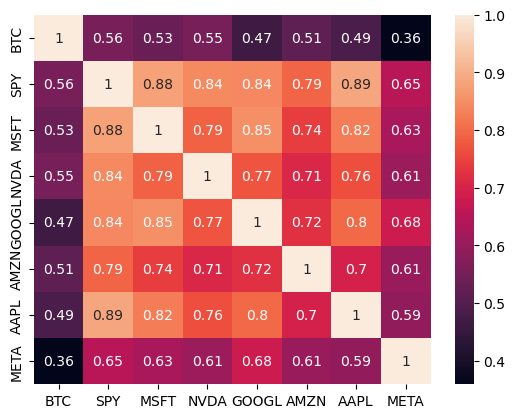

In [29]:
# Plot the correlation matrix 

data_extracted = data_return[
    [
        "BTC","SPY","MSFT","NVDA","GOOGL","AMZN","AAPL","META"
    ]
]

c = data_extracted.corr()
sns.heatmap(c, annot=True)
plt.show()

In [30]:
# Run the regression modelwith all the variable 

model_1 = smf.ols(
    "BTC ~ SPY + MSFT + NVDA + GOOGL + AMZN + AAPL + META",
    data=data_extracted,
).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BTC   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     19.03
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           3.52e-20
Time:                        21:49:54   Log-Likelihood:                 522.56
No. Observations:                 250   AIC:                            -1029.
Df Residuals:                     242   BIC:                            -1001.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0015      0.002     -0.792      0.429      -0.005       0.002
SPY            0.4998      0.386      1.294      0.197      -0.261       1.261
MSFT           0.3286      0.205      1.606      0.110      -0.075       0.732
NVDA           0.2563      0.093      2.746      0.006       0.072       0.440
GOOGL         -0.2211      0.172     -1.283      0.201      -0.560       0.118
AMZN           0.2101      0.103      2.031      0.043       0.006       0.414
AAPL          -0.0784      0.191     -0.410      0.682      -0.455       0.298
META          -0.0414      0.067     -0.617      0.538      -0.173       0.091
==============================================================================
Omnibus:                       26.104   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.656
Skew:                           0.040   Prob(JB):                     5.18e-28
Kurtosis:                       6.472   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Run the regression model on SPY against other independent variables

model_2 = smf.ols(
    "SPY ~ MSFT + NVDA + GOOGL + AMZN + AAPL + META",
    data=data_extracted,
).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     340.2
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          3.51e-115
Time:                        21:49:54   Log-Likelihood:                 970.89
No. Observations:                 250   AIC:                            -1928.
Df Residuals:                     243   BIC:                            -1903.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.530      0.596      -0.000       0.001
MSFT           0.1533      0.033      4.711      0.000       0.089       0.217
NVDA           0.0827      0.015      5.680      0.000       0.054       0.111
GOOGL          0.0382      0.029      1.339      0.182      -0.018       0.094
AMZN           0.0785      0.016      4.782      0.000       0.046       0.111
AAPL           0.2438      0.028      8.820      0.000       0.189       0.298
META           0.0109      0.011      0.979      0.328      -0.011       0.033
==============================================================================
Omnibus:                        5.960   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.649
Skew:                           0.340   Prob(JB):                       0.0593
Kurtosis:                       3.283   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# Calculate the VIF for each independent variable 

labels = [
    "Intercept","SPY","MSFT","NVDA","GOOGL","AMZN","AAPL","META"
]

variables = model_1.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

pd.DataFrame(vif[1:], labels[1:], columns=["VIF"])

VIF
SPY    9.400364
MSFT   5.602532
NVDA   3.730028
GOOGL  4.757286
AMZN   2.871679
AAPL   4.972002
META   1.992640

In [33]:
# Run the PCA for the independent variable 

pc = data_return[
    [
        "SPY","MSFT","NVDA","GOOGL","AMZN","AAPL","META"
    ]
]

pca_data = preprocessing.scale(pc)
pca = PCA(n_components=7)
pca.fit(pca_data)

PCA(n_components=7)

In [34]:
# Tabulate the variance explained for each principal component

pr_var = pca.explained_variance_ratio_
cum_pr = np.cumsum(pca.explained_variance_ratio_)
ind = ["Proportion of variance", "Cumulative proportion of variance"]
cols = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"]
pd.DataFrame(np.vstack((pr_var, cum_pr)), ind, columns=cols)

PC1       PC2       PC3       PC4  \
Proportion of variance             0.785664  0.070136  0.047288  0.035582   
Cumulative proportion of variance  0.785664  0.855800  0.903088  0.938670   

                                        PC5       PC6       PC7  
Proportion of variance             0.029298  0.020275  0.011758  
Cumulative proportion of variance  0.967967  0.988242  1.000000

In [35]:
# The linear combination of the variables in each principal component

pc_res = pd.DataFrame(pca.components_.T, index=list(pc.columns), columns=cols)
pc_res

PC1       PC2       PC3       PC4       PC5       PC6       PC7
SPY    0.406973  0.179599 -0.028194 -0.003828  0.229430  0.099786  0.859484
MSFT   0.394527  0.175614 -0.139122  0.231193 -0.333823  0.760326 -0.226206
NVDA   0.378265  0.159892 -0.059018 -0.884305 -0.069660 -0.062970 -0.192492
GOOGL  0.390493 -0.018272 -0.217876  0.258580 -0.628954 -0.578757  0.048007
AMZN   0.361806 -0.004883  0.908506  0.127030  0.031244 -0.086410 -0.138238
AAPL   0.384382  0.266240 -0.294901  0.283495  0.637806 -0.236757 -0.388821
META   0.323265 -0.916568 -0.128634 -0.034201  0.166482  0.097472 -0.021670

In [36]:
# The regression run using the variable with largest weight for the top 5 principal components

model_3 = smf.ols(
    "BTC ~ SPY + META + AMZN + NVDA + AAPL",
    data=data_extracted,
).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BTC   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     25.89
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           6.04e-21
Time:                        21:49:54   Log-Likelihood:                 520.94
No. Observations:                 250   AIC:                            -1030.
Df Residuals:                     244   BIC:                            -1009.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.002     -0.741      0.460      -0.005       0.002
SPY            0.6199      0.362      1.711      0.088      -0.094       1.333
META          -0.0565      0.065     -0.875      0.382      -0.184       0.071
AMZN           0.2167      0.103      2.113      0.036       0.015       0.419
NVDA           0.2583      0.092      2.808      0.005       0.077       0.439
AAPL          -0.0664      0.186     -0.358      0.721      -0.432       0.299
==============================================================================
Omnibus:                       26.157   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.901
Skew:                           0.069   Prob(JB):                     7.55e-28
Kurtosis:                       6.460   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model_4 = smf.ols(
    "BTC ~ MSFT + NVDA + GOOGL + AMZN + AAPL + META",
    data=data_extracted,
).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BTC   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     21.86
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           1.60e-20
Time:                        21:49:54   Log-Likelihood:                 521.70
No. Observations:                 250   AIC:                            -1029.
Df Residuals:                     243   BIC:                            -1005.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.002     -0.747      0.456      -0.005       0.002
MSFT           0.4052      0.196      2.066      0.040       0.019       0.792
NVDA           0.2977      0.088      3.389      0.001       0.125       0.471
GOOGL         -0.2020      0.172     -1.175      0.241      -0.541       0.137
AMZN           0.2493      0.099      2.518      0.012       0.054       0.444
AAPL           0.0435      0.167      0.261      0.794      -0.285       0.372
META          -0.0359      0.067     -0.536      0.593      -0.168       0.096
==============================================================================
Omnibus:                       25.687   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.763
Skew:                          -0.019   Prob(JB):                     3.63e-27
Kurtosis:                       6.419   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [39]:
# Get data
tech_stocks = ['AAPL', 'MSFT']
stock_data = yf.download(tech_stocks, start='2022-01-01', end='2023-01-01')['Close']
daily_returns = stock_data.pct_change().dropna()

[*********************100%%**********************]  2 of 2 completed


In [40]:
# Rescale and apply PCA
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(daily_returns)

pca = PCA()
principal_components = pca.fit_transform(scaled_returns)

Text(0, 0.5, 'MSFT Returns')

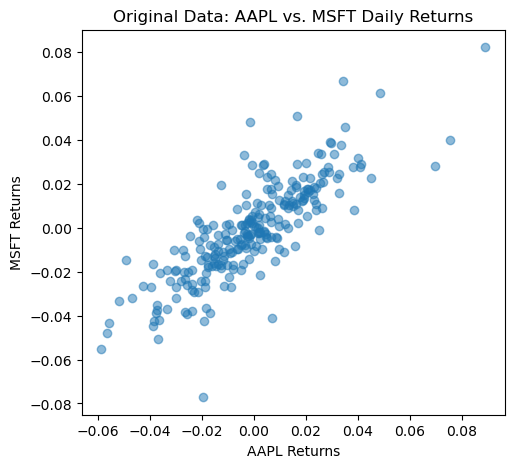

In [41]:
# Plot original data (AAPL vs. MSFT returns)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(daily_returns['AAPL'], daily_returns['MSFT'], alpha=0.5)
plt.title('Original Data: AAPL vs. MSFT Daily Returns')
plt.xlabel('AAPL Returns')
plt.ylabel('MSFT Returns')

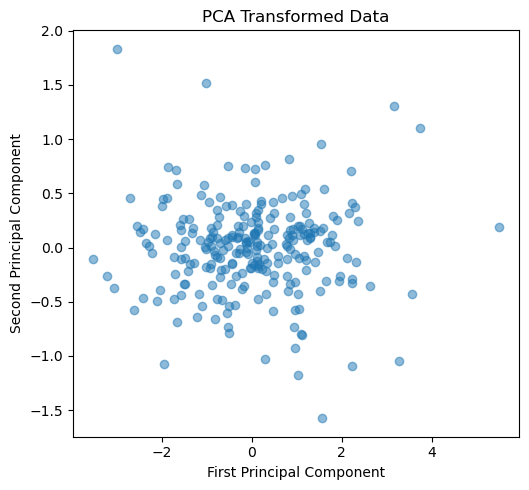

In [42]:
# Plot PCA transformed data (First vs. Second Principal Component)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.title('PCA Transformed Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

In [43]:
pca.explained_variance_ratio_

array([0.91234541, 0.08765459])

In [44]:
#Libraries we need to import

import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kurtosis, skewnorm
import yfinance as yf
from statsmodels.stats.stattools import jarque_bera
import pylab
from arch.unitroot import ADF, KPSS
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

In [45]:
# 1. Adjusted Dickly-Fuller Test method (ADF)
# In this method, our null hypotheis is that there is an unit root present in the time series, which makes our time series non-stationary

# 2. Kwiatkowski-Phillips-Schmidt-Shin Test method (KSPP)
# In this method, our null hypothesis is that there is no trend in our time series, which makes them stationary.

# we need make decision based on both above test as foloowing -

# If the ADF rejects the null hypothesis while KSPP not, then we can say our time series is stationary.
# If the KSPP accepts the null hypothesis while KSPP accepts it, then we can say time series is non-staionary.
# In other cases, we have to conduct some other tests or transform the data.

def downloadData(ticker,start_date,end_date):

    """
    Function "downloadData" downloads the data for us using yfinace module.
    Particularly it downloads and converts into the Adjusted close daily percentage data.
    This function takes three arguments namely-
    1) ticker : ticker of stock
    2) start_date : start date from where we want our data
    3) end_date : we want data upto this date
    """
    
    data = yf.download(ticker,start=start_date,end=end_date)
    data["Daily Change"] = data["Adj Close"].pct_change()
    ts_data = pd.Series(data["Daily Change"])
    return data

class UnitTest:

    def __init__(self,data,lags = 0):
        self.data = data
        self.lags = lags
    def adfTest(self,trend='c', method='bic') -> None:
        adfResults = ADF(self.data,lags=self.lags, trend=trend, method=method)
        print(f"ADF test result with {self.lags} lags, '{trend}' trend and '{method}' method: \n",adfResults)
        print("-------------***************-------------")
        return
    def kpssTest(self,trend="c") -> None:
        kpssResults = KPSS(self.data, trend=trend, lags=self.lags)
        print(f"KPSS test result with {self.lags} lags and '{trend}' trend : \n",kpssResults)
        print("-------------***************-------------")
        return

[*********************100%%**********************]  1 of 1 completed
ADF test result with 0 lags, 'c' trend and 'bic' method: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.522
P-value                         0.986
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
-------------***************-------------

KPSS test result with 0 lags and 'c' trend : 
     KPSS Stationarity Test Results   
Test Statistic                203.429
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
-------------***************-------------

ADF 

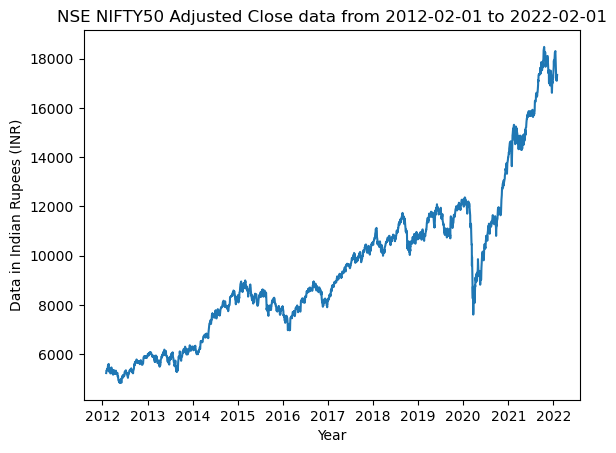

In [46]:
data = pd.DataFrame(downloadData(ticker = "^NSEI",start_date="2012-02-01",end_date="2022-02-01")["Adj Close"])
plt.plot(data)
plt.title("NSE NIFTY50 Adjusted Close data from 2012-02-01 to 2022-02-01")
plt.xlabel("Year")
plt.ylabel("Data in Indian Rupees (INR)")

Test = UnitTest(data = data)
Test.adfTest(trend='c')
print()
Test.kpssTest(trend='c')
print()
Test.adfTest(trend='n')
print()
Test.adfTest(trend='ct')
print()
Test.kpssTest(trend='ct')

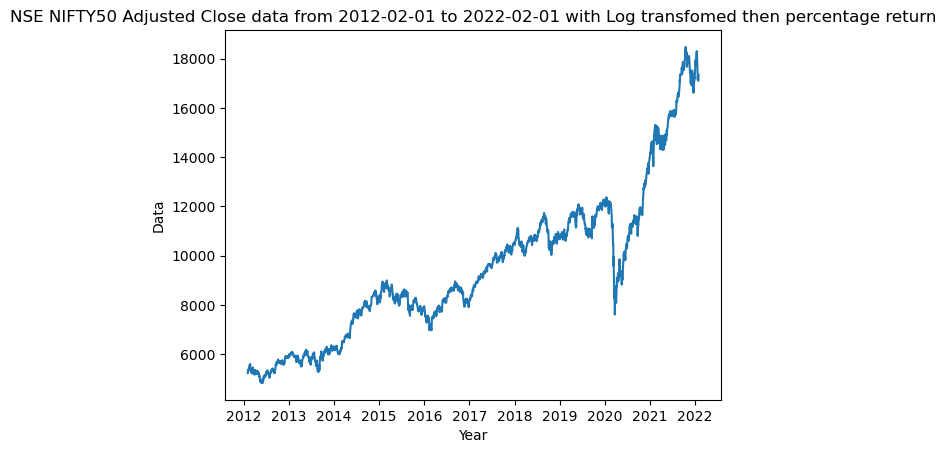

ADF test result with 0 lags, 'c' trend and 'bic' method: 
    Augmented Dickey-Fuller Results   
Test Statistic                -49.330
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
-------------***************-------------

KPSS test result with 0 lags and 'c' trend : 
     KPSS Stationarity Test Results   
Test Statistic                  0.048
P-value                         0.889
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
-------------***************-------------

ADF test result with 0 lags, 'n' trend and 'bic' method: 
    Augmented D

In [47]:
transformedData = np.log(data).diff().dropna()
plt.plot(data)
plt.title("NSE NIFTY50 Adjusted Close data from 2012-02-01 to 2022-02-01 with Log transfomed then percentage return")
plt.xlabel("Year")
plt.ylabel("Data")
plt.show()
Test = UnitTest(data = transformedData)

"""
”n” - No trend components
”c” - Include a constant (Default)
”ct” - Include a constant and linear time trend
"""
Test.adfTest(trend='c')
print()
Test.kpssTest(trend='c')
print()
Test.adfTest(trend='n')
print()
Test.adfTest(trend='ct')
print()
Test.kpssTest(trend='ct')

In [48]:
# Regime Change Model
# we are going to use the Three-state Variance Switching by Kim, Nelson, and Startz (1998), which only can be used when our data has no Autoregression component. And which we already confirmed by transforming our data above and checking it by using Unit Testing.

mod_kns = sm.tsa.MarkovRegression(
    transformedData, k_regimes=3, trend="n", switching_variance=True
)
Result = mod_kns.fit()

In [49]:
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2448
Model:               MarkovRegression   Log Likelihood                8018.430
Date:                Tue, 12 Sep 2023   AIC                         -16018.860
Time:                        21:50:06   BIC                         -15966.633
Sample:                             0   HQIC                        -15999.879
                               - 2448                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   6.52e-06     16.136      0.000    9.24e-05       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.891e-05   3.29e-06     11.829      0.000    3.25e-05    4.54e-05
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012      0.000      4.781      0.000       0.001       0.002
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9832      0.005    203.309      0.000       0.974       0.993
p[1->0]        0.0172      0.000     90.066      0.000       0.017       0.018
p[2->0]        0.0963      0.043      2.252      0.024       0.012       0.180
p[0->1]        0.0113      0.004      2.821      0.005       0.003       0.019
p[1->1]        0.9828        nan        nan        nan         nan         nan
p[2->1]     3.506e-11        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

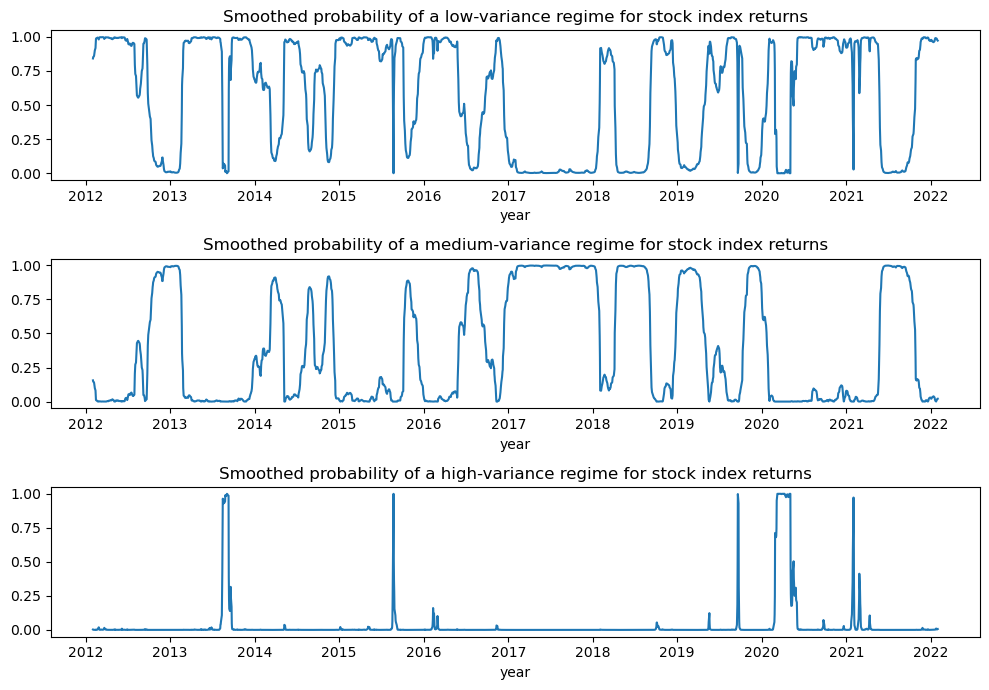

In [50]:
fig, axes = plt.subplots(3, figsize=(10, 7))
ax = axes[0]
ax.plot(Result.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-variance regime for stock index returns",xlabel="year")
ax = axes[1]
ax.plot(Result.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a medium-variance regime for stock index returns",xlabel="year")
ax = axes[2]
ax.plot(Result.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of a high-variance regime for stock index returns",xlabel="year")

fig.tight_layout()
